In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from scipy.stats import mode

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

model_number = 'stacking'
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [2]:
# Create datasets
train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset()
x_test_real = kaggle.load_test_set()

In [7]:
filepaths_to_load = {
    'model6/VGG_6_79': 0.79,
    'model7/DeeperVGG_4_79': 0.79,
    'model7/DeeperVGG_6_84': 0.84,
    'model8/VGGRes_3_79': 0.79,
    'model9/DeeperVGG2_2_84': 0.84
}

valid_predictions = np.zeros((2378, 11, len(filepaths_to_load)))
test_predictions = np.zeros((17831, 11, len(filepaths_to_load)))

for index, filepath in enumerate(filepaths_to_load):
    print(f'Loading and predicting {filepath}')
    model = keras.models.load_model(f'models/{filepath}')
    softmax_valid_pred = np.array(tf.nn.softmax(model.predict(valid_dataset.batch(128))))
    softmax_test_pred = np.array(tf.nn.softmax(model.predict(x_test_real)))
    
    valid_predictions[:, :, index] = softmax_valid_pred
    test_predictions[:, :, index] = softmax_test_pred

Loading and predicting model7/DeeperVGG_6_84
Loading and predicting model9/DeeperVGG2_2_84


In [9]:
# Determine best weighting factors (possibly overfitting since we are using valid set for selection)
for probability_power in range(2, 15):
    for accuracy_power in range(2, 15):
        print(f'Prob power:{probability_power}, accuracy power: {accuracy_power}')
        adapted_pred = np.power(valid_predictions, probability_power)
        for index, accuracy in enumerate(filepaths_to_load.values()):
            adapted_pred[:, :, index] *= accuracy**accuracy_power
        adapted_pred = np.sum(adapted_pred, axis=2)
        adapted_pred = np.argmax(adapted_pred, axis=1)
        kaggle.print_accuracy(valid_labels, adapted_pred)

Prob power:2, accuracy power: 10
Accuracy: 0.8684
Prob power:3, accuracy power: 10
Accuracy: 0.8671
Prob power:4, accuracy power: 10
Accuracy: 0.8675
Prob power:5, accuracy power: 10
Accuracy: 0.8675
Prob power:6, accuracy power: 10
Accuracy: 0.8671
Prob power:7, accuracy power: 10
Accuracy: 0.8671
Prob power:8, accuracy power: 10
Accuracy: 0.8671
Prob power:9, accuracy power: 10
Accuracy: 0.8671
Prob power:10, accuracy power: 10
Accuracy: 0.8671
Prob power:11, accuracy power: 10
Accuracy: 0.8671
Prob power:12, accuracy power: 10
Accuracy: 0.8671
Prob power:13, accuracy power: 10
Accuracy: 0.8671
Prob power:14, accuracy power: 10
Accuracy: 0.8671


Accuracy: 0.8671


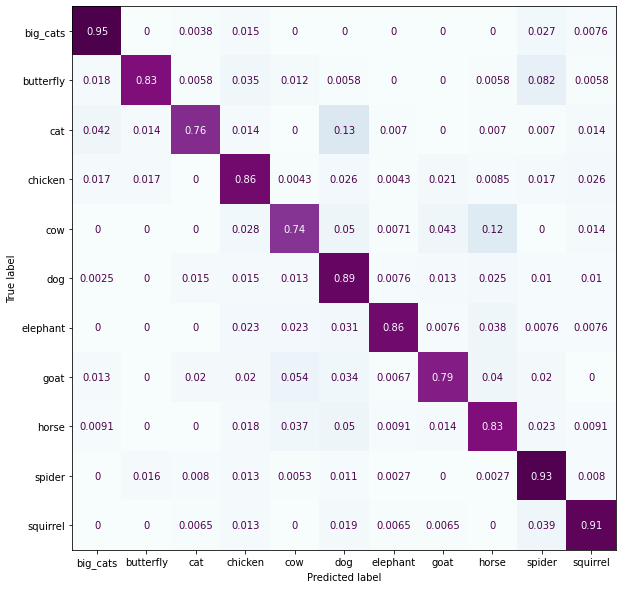

In [10]:
modified_valid_predictions = np.power(valid_predictions, 3)
for index, accuracy in enumerate(filepaths_to_load.values()):
    modified_valid_predictions[:, :, index] *= accuracy**8
modified_valid_predictions = np.sum(modified_valid_predictions, axis=2)
modified_valid_predictions = np.argmax(modified_valid_predictions, axis=1)

kaggle.print_accuracy(valid_labels, modified_valid_predictions)
kaggle.plot_confusion_matrix(valid_labels, modified_valid_predictions)

In [6]:
modified_test_predictions = np.power(test_predictions, 3)
for index, accuracy in enumerate(filepaths_to_load.values()):
    modified_test_predictions[:, :, index] *= accuracy**10
modified_test_predictions = np.sum(modified_test_predictions, axis=2)
modified_test_predictions = np.argmax(modified_test_predictions, axis=1)
kaggle.save_test_pred('models/stacking/basic_stacking_test2.csv', modified_test_predictions)